In [1]:
import os
import pandas as pd
import numpy as np
import random as rd
import datetime as dt
import re
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
import time
import csv
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import metrics
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, explained_variance_score, mean_absolute_error, mean_squared_error, roc_curve, roc_auc_score, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.compose import  ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelBinarizer, RobustScaler
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, CategoricalNB, BernoulliNB
from sklearn.svm import SVC  
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, SMOTENC
from itertools import cycle
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import AdaBoostClassifier


import joblib

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)

# Step 1: Load libraries and dataset

In [2]:
#load in data
df = pd.read_csv('./Attrition Data (for viz) v2.csv', encoding='utf-8')

## Selecting Features

In [18]:
#Get number of unique values for each discrete variable in the dataset.
for col in df.describe().columns:
    if df[col].dtype == int:
        print(f'{col}:', df[col].nunique())

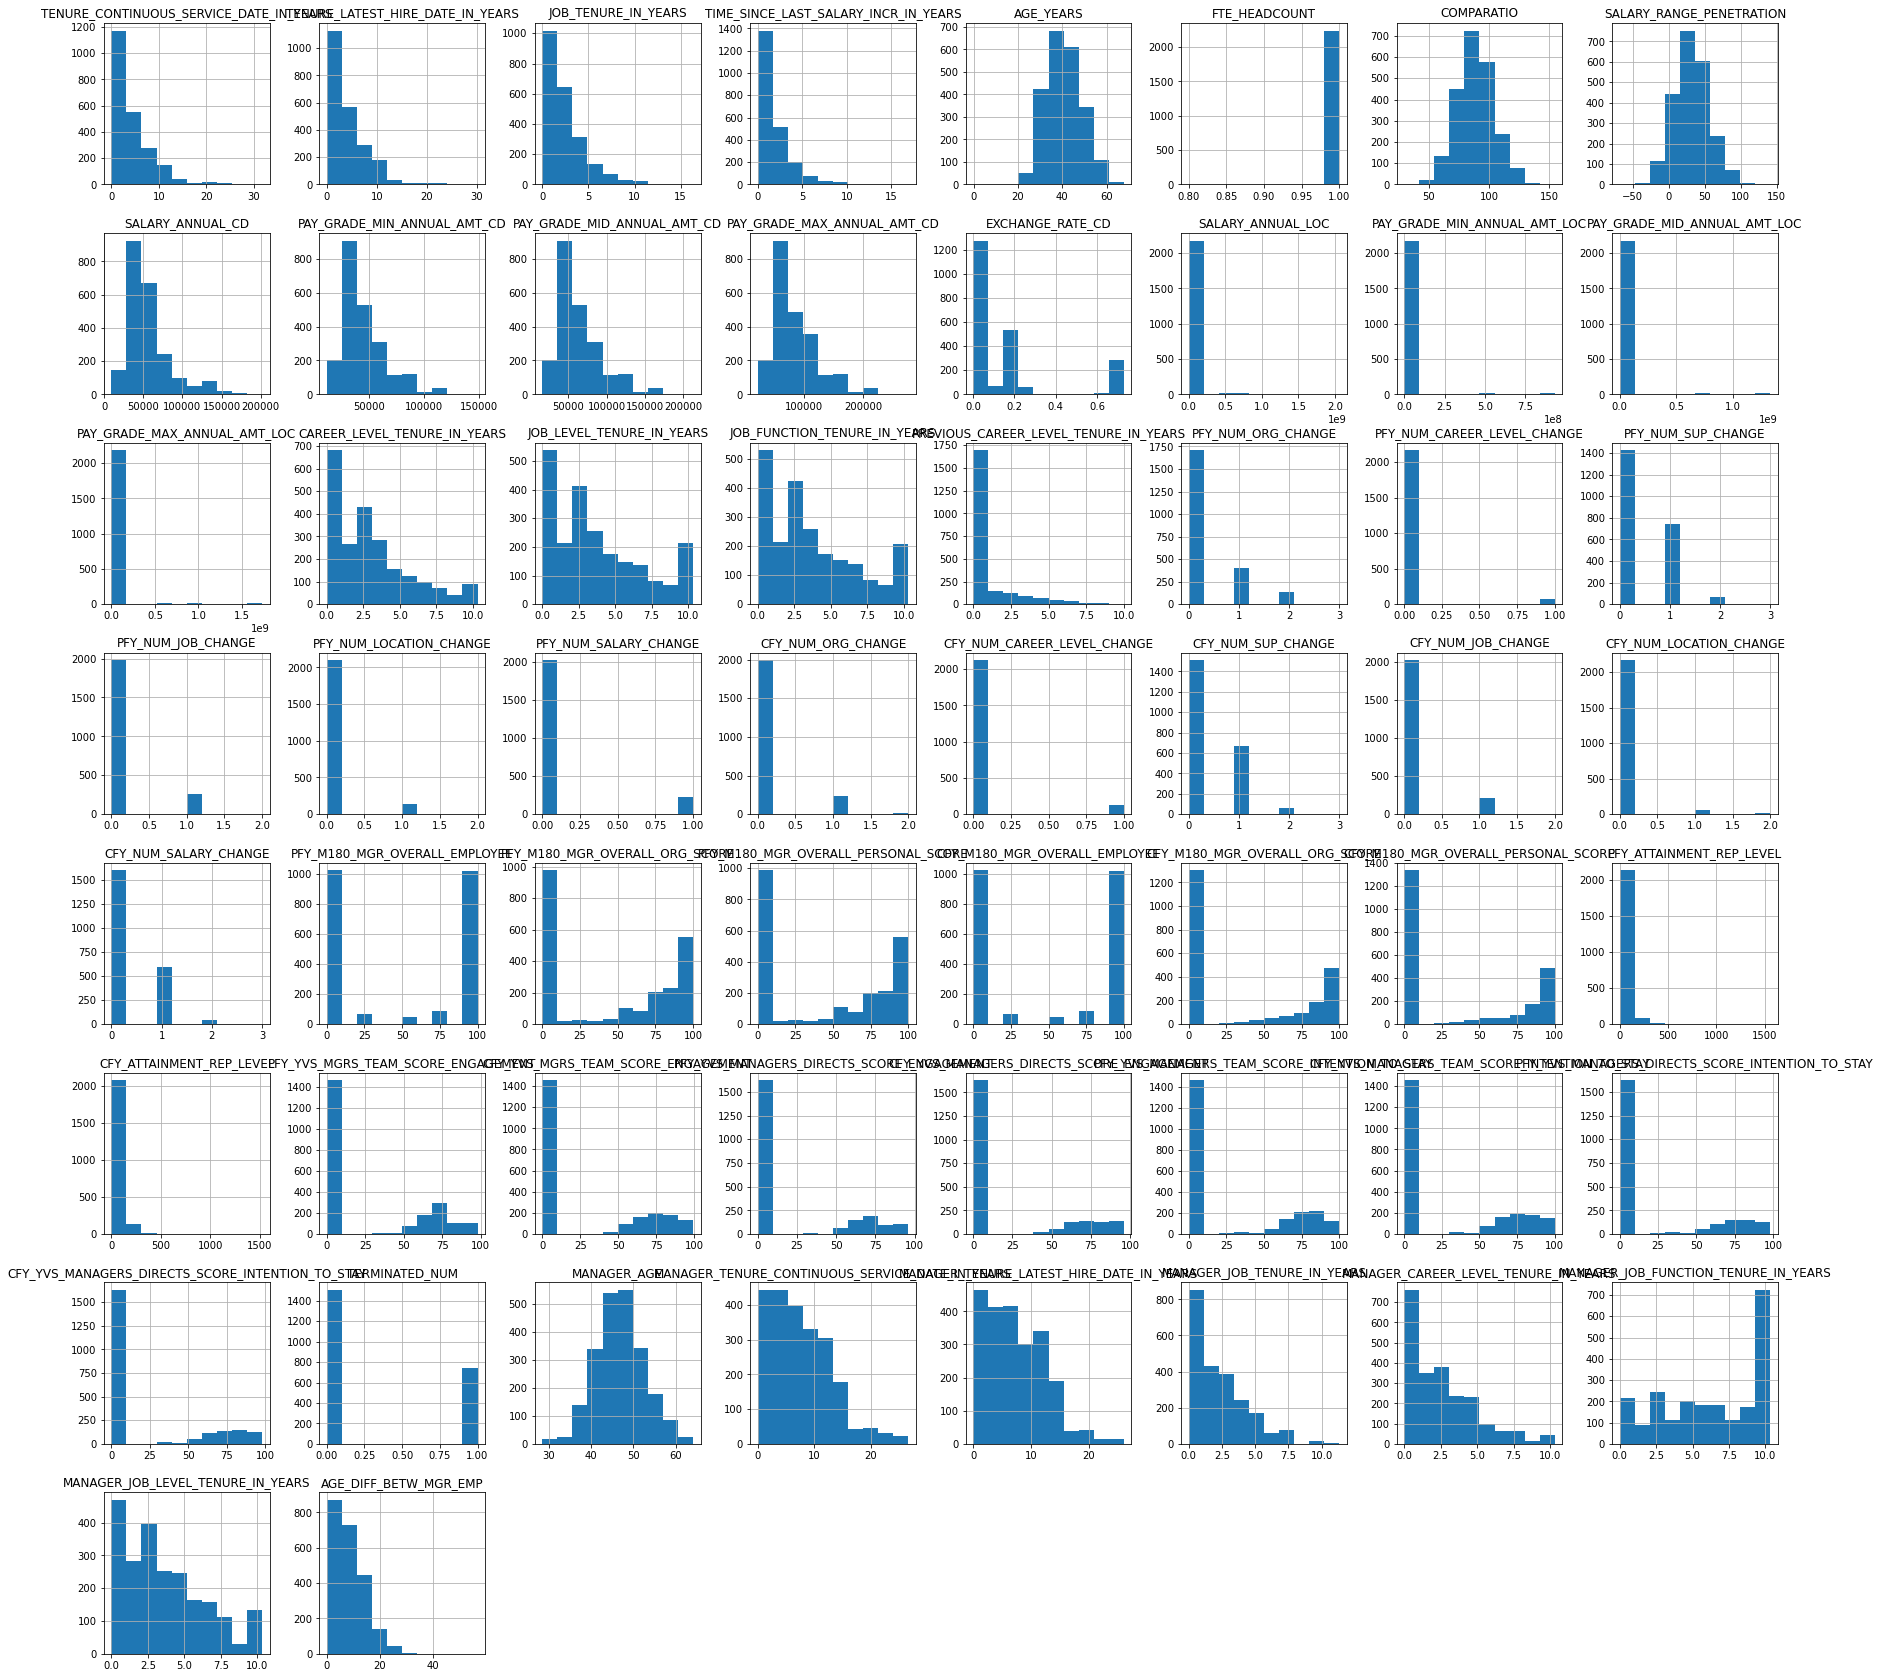

In [19]:
#Plot histogram of all columns
df[df.describe().columns].hist(figsize=(30,30));

<AxesSubplot:>

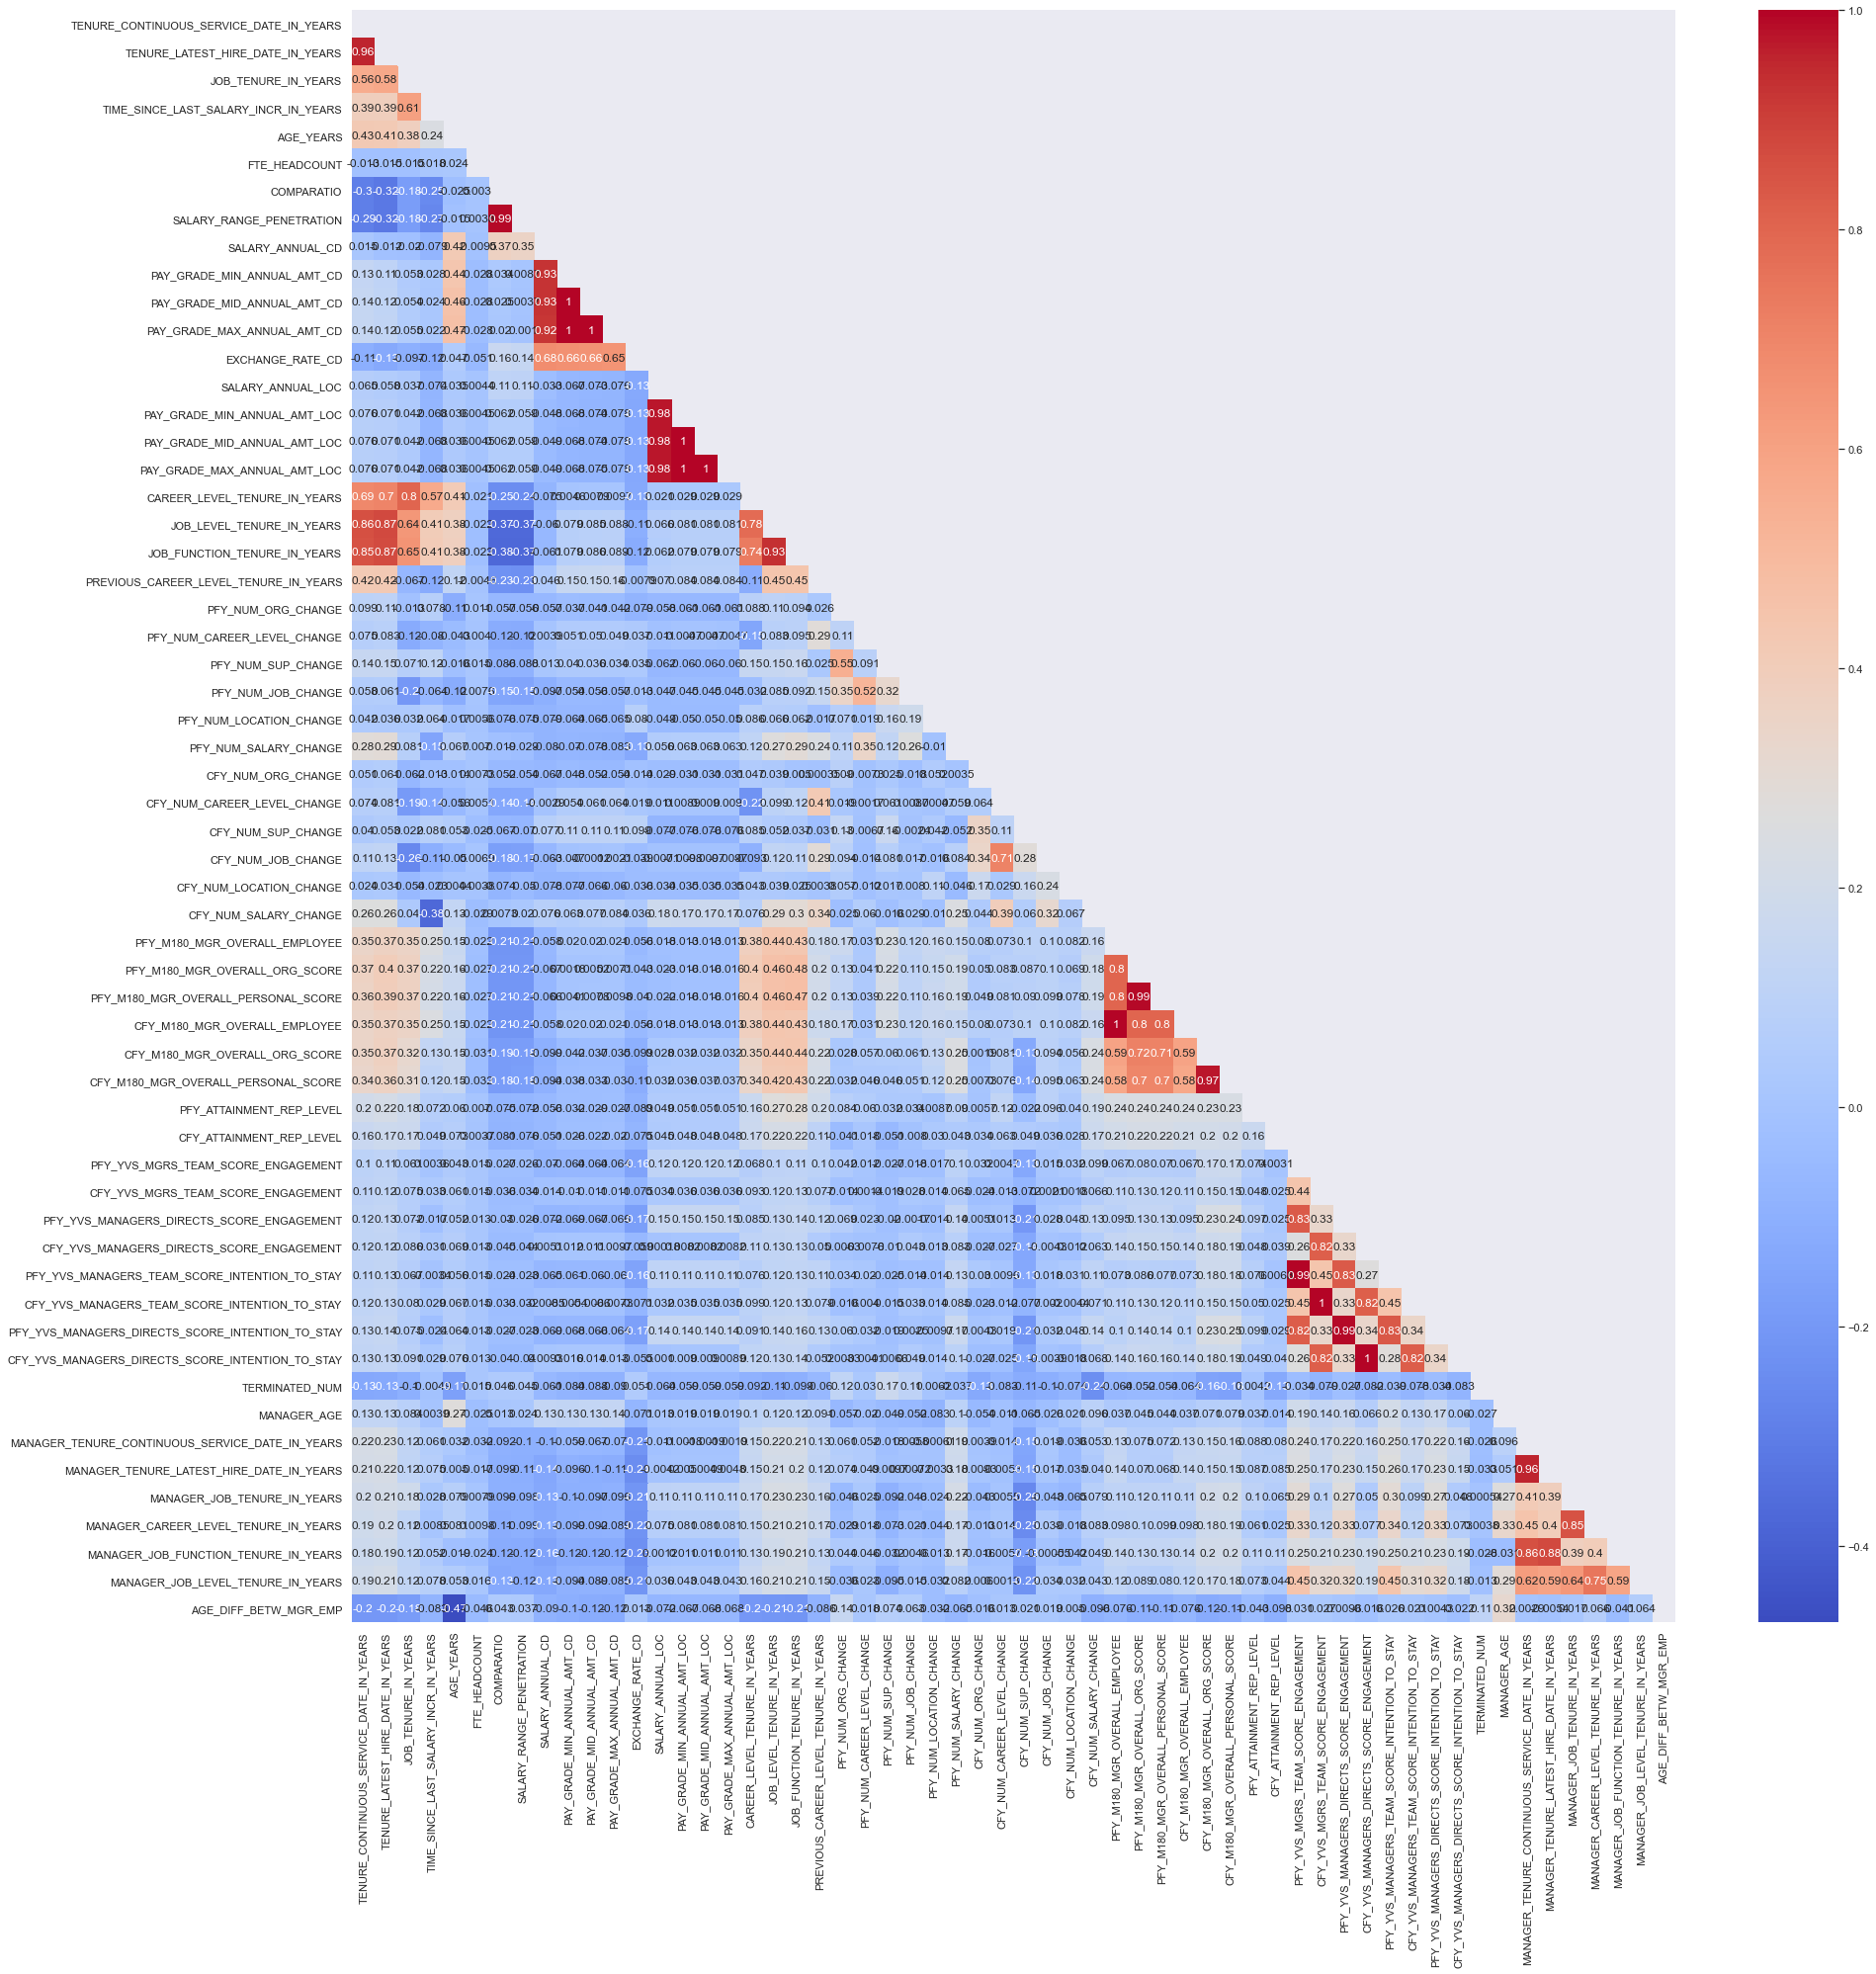

In [20]:
#Correlation matrix; only works for numeric data
sns.set(rc = {'figure.figsize':(30,30)})
sns.heatmap(df.corr(), annot=True, cmap = 'coolwarm', mask=np.triu(df.corr()),)

In [23]:
#Drop numercial and categorical
df2 = df.drop(numerical_cols_to_drop, axis = 1)
df2 = df2.drop(categorical_cols_to_drop, axis = 1)

In [24]:
#Save to csv
df2.to_csv('./1. Data/df2_dataviz.csv', index=False)

<AxesSubplot:>

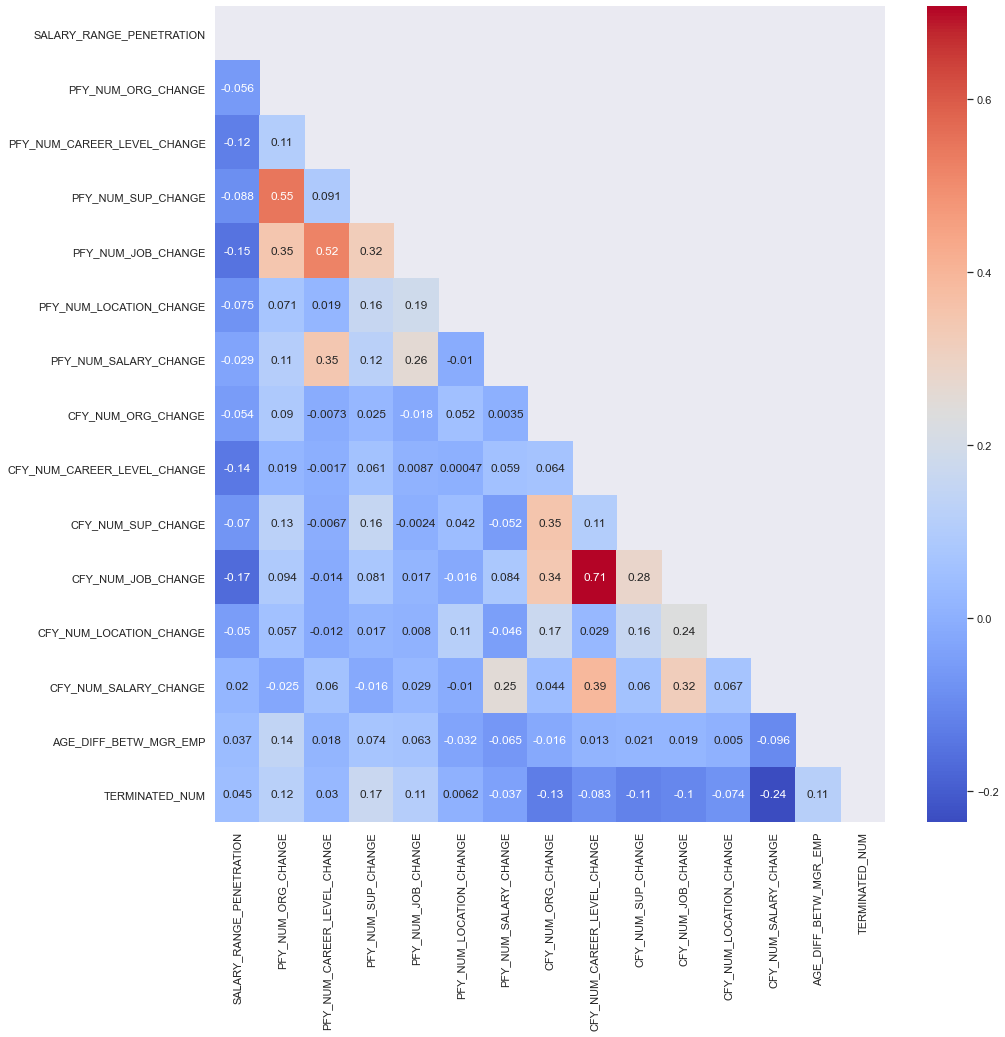

In [25]:
# Drop the column and save it in a new variable
last_column = df2.pop('TERMINATED_NUM')

# Compute the correlation matrix without the last column, then add it back to the end
df2 = pd.concat([df2, last_column], axis=1)

# Plot the heatmap
sns.set(rc={'figure.figsize':(15, 15)})
sns.heatmap(df2.corr(), annot=True, cmap='coolwarm', mask=np.triu(df2.corr()))

In [26]:
df2.shape

(2240, 101)

In [28]:
#Save to csv
corr_matrix.to_csv('./1. Data/corr_matrix.csv', index=False)

In [29]:
#define X and y
X = df2.drop(['TERMINATED_NUM', 'TERMINATED'], axis = 1)
y = df2['TERMINATED_NUM']

In [30]:
X.shape

(2240, 99)

In [31]:
#Split data columns into numerical and categorical
numerical = X.select_dtypes(exclude='object')
categorical = X.select_dtypes(include='object')

#Save data into list
num_columns = list(numerical.columns.values)
cat_columns = list(categorical.columns.values)

In [32]:
# save the new DataFrame to a CSV file
numerical_cols = pd.DataFrame(numerical.columns.values)
numerical_cols.rename(columns={0:"Numerical Columns"},inplace=True)
numerical_cols

,Numerical Columns
0,SALARY_RANGE_PENETRATION
1,PFY_NUM_ORG_CHANGE
2,PFY_NUM_CAREER_LEVEL_CHANGE
3,PFY_NUM_SUP_CHANGE
4,PFY_NUM_JOB_CHANGE
5,PFY_NUM_LOCATION_CHANGE
6,PFY_NUM_SALARY_CHANGE
7,CFY_NUM_ORG_CHANGE
8,CFY_NUM_CAREER_LEVEL_CHANGE
9,CFY_NUM_SUP_CHANGE


In [35]:
#Save to csv
data_cols.to_csv('./1. Data/data_cols.csv', index=False)

In [37]:
#Double check for NA
y.isnull().sum()

0

In [38]:
#Check Shape
print(X.shape)
print(y.shape)

(2240, 99)
(2240,)


# Step 2: Models

##  2.1 Define X and y

In [40]:
#we split the data into 80% training data,20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [42]:
X_train.shape, X_test.shape, X.shape

((1792, 99), (448, 99), (2240, 99))

In [43]:
def get_pipeline(classifier_type, random_search=False, class_weights=None):
    numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown = 'ignore'))])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    if classifier_type == 'BernoulliNB':
        clf = BernoulliNB()
    elif classifier_type == 'RandomForest':
        clf = RandomForestClassifier(class_weight=class_weights)
    elif classifier_type == 'LogisticRegression':
        clf = LogisticRegression(class_weight=class_weights)
    elif classifier_type == 'ExtraTrees':
        clf = ExtraTreesClassifier(class_weight=class_weights)
    elif classifier_type == 'LightGBM':
        clf = LGBMClassifier(class_weight=class_weights)
    elif classifier_type == 'SVM':
        clf = SVC(class_weight=class_weights)
    elif classifier_type == 'AdaBoost':
        clf = AdaBoostClassifier(class_weight=class_weights)
    else:
        raise ValueError(f"Invalid classifier type: {classifier_type}. Choose from 'BernoulliNB', 'RandomForest', 'LogisticRegression', 'ExtraTrees', 'LightGBM', 'SVM', 'AdaBoost'.")
    pipe = Pipeline([('preprocessor', preprocessor), ('clf', clf)])

    return pipe

In [44]:
def run_pipeline(classifier_type, X_train, y_train, X_test, y_test, class_weights=None):
    start = time.time()
    pipe = get_pipeline(classifier_type, class_weights=class_weights)
    model = pipe.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    y_pred_proba = None
    roc_auc = None
    confusion_m = None
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        confusion_m = confusion_matrix(y_test, y_pred)
    elif hasattr(model, 'decision_function'):
        y_pred_decision = model.decision_function(X_test)
        roc_auc = roc_auc_score(y_test, y_pred_decision)
        confusion_m = confusion_matrix(y_test, y_pred)

    cr = classification_report(y_test, y_pred, output_dict=True)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_cv_score = np.mean(cv_scores)

    result = {'Classifier': classifier_type,
            'Precision': round(precision, 3),
            'Recall': round(recall, 3),
            'F1-Score': round(f1_score, 3),
            'Accuracy (Train)': round(train_accuracy, 3),
            'Accuracy (Test)': round(accuracy, 3),
            'Accuracy (Difference)': round(train_accuracy, 3) - round(accuracy, 3),
            'ROC AUC': round(roc_auc, 3),
            'CV Score': round(mean_cv_score, 3)}
    
    if confusion_m is not None:
        result['Confusion Matrix'] = confusion_m

    end = time.time()
    time_taken = end - start
    result['Time (s)'] = round(time_taken, 2)
    return result


In [45]:
results = []

classifiers = ['BernoulliNB', 'LogisticRegression','RandomForest',  'ExtraTrees', 'LightGBM', 'SVM']

for classifier in classifiers:
    result = run_pipeline(classifier, X_train, y_train, X_test, y_test)
    results.append(result)

df = pd.DataFrame(results)
df


,Classifier,Precision,Recall,F1-Score,Accuracy (Train),Accuracy (Test),Accuracy (Difference),ROC AUC,CV Score,Confusion Matrix,Time (s)
0,BernoulliNB,0.780,0.770,0.773,0.729,0.770,-0.041,0.801,0.713,"[[243, 61], [42, 102]]",0.32
1,LogisticRegression,0.813,0.817,0.811,0.876,0.817,0.059,0.836,0.815,"[[277, 27], [55, 89]]",0.56
2,RandomForest,0.858,0.850,0.841,1.000,0.850,0.150,0.870,0.829,"[[295, 9], [58, 86]]",3.98
3,ExtraTrees,0.837,0.833,0.822,1.000,0.833,0.167,0.852,0.824,"[[291, 13], [62, 82]]",4.82
4,LightGBM,0.840,0.842,0.836,1.000,0.842,0.158,0.902,0.858,"[[284, 20], [51, 93]]",1.36
5,SVM,0.841,0.826,0.809,0.900,0.826,0.074,0.845,0.817,"[[297, 7], [71, 73]]",4.30


In [46]:
results = []
classifiers = ['BernoulliNB', 'LogisticRegression','RandomForest',  'ExtraTrees', 'LightGBM', 'SVM']
class_weights = {0: 1, 1: 10} # custom class weights

#Weights for LightGBM for balanced
#To balance the class weights, you need to determine the ratio of the classes in your target variable. 
#For example, if you have a binary classification problem and 90% of the examples belong to class 0 and 10% belong to class 1, then the class weights would be scale_pos_weight=10 or class_weight={0: 1, 1: 10}. 
#You can also use other metrics, such as F1-score, to determine the optimal class weights.
total_samples = X_train.shape[0]
class_0_samples = y_train[y_train == 0].shape[0]
class_1_samples = y_train[y_train == 1].shape[0]

class_weight = {0: total_samples/class_0_samples, 1: total_samples/class_1_samples}
class_weight

for classifier in classifiers:
    if classifier == 'RandomForest' or classifier == 'LogisticRegression':
        result = run_pipeline(classifier, X_train, y_train, X_test, y_test, class_weights='balanced')
    elif classifier == 'ExtraTrees':
        result = run_pipeline(classifier, X_train, y_train, X_test, y_test, class_weights='balanced')
    elif classifier == 'LightGBM':
        result = run_pipeline(classifier, X_train, y_train, X_test, y_test, class_weights=class_weight)
    elif classifier == 'SVM':
        result = run_pipeline(classifier, X_train, y_train, X_test, y_test, class_weights='balanced')
    else:
        result = run_pipeline(classifier, X_train, y_train, X_test, y_test)
    results.append(result)

df_classweights = pd.DataFrame(results)
df_classweights


,Classifier,Precision,Recall,F1-Score,Accuracy (Train),Accuracy (Test),Accuracy (Difference),ROC AUC,CV Score,Confusion Matrix,Time (s)
0,BernoulliNB,0.780,0.770,0.773,0.729,0.770,-0.041,0.801,0.713,"[[243, 61], [42, 102]]",0.31
1,LogisticRegression,0.791,0.783,0.786,0.860,0.783,0.077,0.835,0.781,"[[248, 56], [41, 103]]",0.57
2,RandomForest,0.835,0.830,0.819,1.000,0.830,0.170,0.875,0.829,"[[291, 13], [63, 81]]",3.83
3,ExtraTrees,0.858,0.848,0.837,1.000,0.848,0.152,0.856,0.829,"[[296, 8], [60, 84]]",4.58
4,LightGBM,0.834,0.837,0.834,0.998,0.837,0.161,0.896,0.856,"[[276, 28], [45, 99]]",1.23
5,SVM,0.818,0.821,0.818,0.921,0.821,0.100,0.846,0.806,"[[272, 32], [48, 96]]",4.46


In [47]:
df

,Classifier,Precision,Recall,F1-Score,Accuracy (Train),Accuracy (Test),Accuracy (Difference),ROC AUC,CV Score,Confusion Matrix,Time (s)
0,BernoulliNB,0.780,0.770,0.773,0.729,0.770,-0.041,0.801,0.713,"[[243, 61], [42, 102]]",0.32
1,LogisticRegression,0.813,0.817,0.811,0.876,0.817,0.059,0.836,0.815,"[[277, 27], [55, 89]]",0.56
2,RandomForest,0.858,0.850,0.841,1.000,0.850,0.150,0.870,0.829,"[[295, 9], [58, 86]]",3.98
3,ExtraTrees,0.837,0.833,0.822,1.000,0.833,0.167,0.852,0.824,"[[291, 13], [62, 82]]",4.82
4,LightGBM,0.840,0.842,0.836,1.000,0.842,0.158,0.902,0.858,"[[284, 20], [51, 93]]",1.36
5,SVM,0.841,0.826,0.809,0.900,0.826,0.074,0.845,0.817,"[[297, 7], [71, 73]]",4.30


In [48]:
df_classweights

,Classifier,Precision,Recall,F1-Score,Accuracy (Train),Accuracy (Test),Accuracy (Difference),ROC AUC,CV Score,Confusion Matrix,Time (s)
0,BernoulliNB,0.780,0.770,0.773,0.729,0.770,-0.041,0.801,0.713,"[[243, 61], [42, 102]]",0.31
1,LogisticRegression,0.791,0.783,0.786,0.860,0.783,0.077,0.835,0.781,"[[248, 56], [41, 103]]",0.57
2,RandomForest,0.835,0.830,0.819,1.000,0.830,0.170,0.875,0.829,"[[291, 13], [63, 81]]",3.83
3,ExtraTrees,0.858,0.848,0.837,1.000,0.848,0.152,0.856,0.829,"[[296, 8], [60, 84]]",4.58
4,LightGBM,0.834,0.837,0.834,0.998,0.837,0.161,0.896,0.856,"[[276, 28], [45, 99]]",1.23
5,SVM,0.818,0.821,0.818,0.921,0.821,0.100,0.846,0.806,"[[272, 32], [48, 96]]",4.46


# Choose Logistic Regression

In [49]:
#define the numeric transformer
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

#define the categorical transformer
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

#define the preprocessor step using columntransformer for both numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [ ]:
#define dummy classifier
clf = LogisticRegression()

#define pipeline - chain the preprocessor step and classifier
pipe = Pipeline([('preprocessor',preprocessor), ('clf',clf)])

In [51]:
#randomised search cv with hyper parameters
skf = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)
#input the parameters for search space
param_grid = {
    'clf__C':[0.1, 0.5, 1.0, 5.0, 10.0],
    'clf__penalty':['l1','l2', 'elasticnet'],
    'clf__solver': ['lbfgs','liblinear', 'sag', 'saga'],
}

#create the random forest classifier object
#use scoring = 'f1_macro' as there are imbalanced classes
rscv_lr = RandomizedSearchCV(estimator = pipe, param_distributions=param_grid, scoring='f1_macro', cv=skf, verbose=1, random_state=43)

In [52]:
%%time
#fit the naive model with X_train and y_train data
lr_model = rscv_lr.fit(X_train, y_train)

#use the naive_model to predict the X_test values
y_pred_lr = lr_model.predict(X_test)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 3.89 s


In [53]:
lr_cross_val = cross_val_score(lr_model, X_train, y_train, cv = skf, scoring='f1_macro')
print(lr_cross_val.mean())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.782871917739931


In [54]:
print ('Best parameters found by randomised search are:', lr_model.best_params_)
print ('Best accuracy from randomised search is:', lr_model.best_score_)

Best parameters found by randomised search are: {'clf__solver': 'saga', 'clf__penalty': 'l2', 'clf__C': 0.5}
Best accuracy from randomised search is: 0.7901171128904829


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance

imps = permutation_importance(lr_model, X_test, y_test, n_repeats=15)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(imps.importances_mean)[::-1]

# Save all the features and their importances in a DataFrame
all_features_lr = pd.DataFrame({'Feature_lr': X.columns[indices],
                             'Importance': importances[indices]})
all_features_lr = all_features_lr[all_features_lr['Feature_lr'] != 'HCM_PERSON_NUMBER']

# Format 'Importance' to 4 decimal places
all_features_lr['Importance'] = all_features_lr['Importance'].apply(lambda x: "{:.4f}".format(x))

# Print the top 10 features
print("Top 10 Features:")
print(all_features_lr.head(10))

# Sort the DataFrame by 'Importance' in descending order
all_features_lr.sort_values(by='Importance', ascending=False, inplace=True)

In [ ]:
top10_bar_lr = all_features_lr.head(10).sort_values(by='Importance', ascending=True)
# Plot the top 10 features
plt.figure(figsize=(10, 8))
plt.barh(top10_bar_lr.iloc[:10, 0], top10_bar_lr.iloc[:10, 1].astype(float), color="#2C5967", align='center')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title('Logistic Regression Permutation Importance')
plt.show()

In [ ]:
top10_lr = all_features_lr.head(10)


In [58]:
#Save to csv
top10_lr.to_csv('./1. Data/top10_lr.csv', index=False)

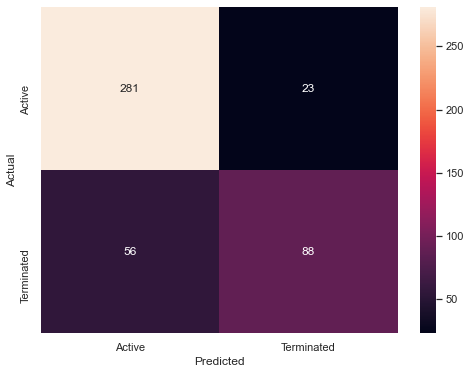

In [59]:
#Plot Confusion Matrix

#plot confusion matrix

conf_mat_lr = confusion_matrix(y_test, y_pred_lr)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat_lr, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')

ax.xaxis.set_ticklabels(['Active', 'Terminated'])
ax.yaxis.set_ticklabels(['Active', 'Terminated'])


plt.show()

In [60]:
#Plot confusion matrix in dataframe
conf_mat_lr_df = pd.DataFrame(conf_mat_lr, columns = ['Predicted as Active', 'Predicted as Terminated'], index = ['Active', 'Terminated'] )
conf_mat_lr_df

,Predicted as Active,Predicted as Terminated
Active,281,23
Terminated,56,88


In [61]:
#Sensitivity and Specificity
pred_proba_lr_df = pd.DataFrame({'true_values': y_test, 'pred_probs': lr_model.predict_proba(X_test)[:,1]})
pred_proba_lr_df.head()

,true_values,pred_probs
2128,0,0.152093
672,1,0.829708
233,1,0.936759
1475,0,0.049552
1651,0,0.165095


# Choose Light GBM

In [62]:
#define the numeric transformer
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

#define the categorical transformer
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

#define the preprocessor step using columntransformer for both numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [ ]:
#define classifier
clf = LGBMClassifier(objective = 'binary', metric = 'binary_logloss')

#define the pipeline - chain the preprocessor step and the classifier
pipe = Pipeline([('preprocessor',preprocessor), ('clf',clf)])
pipe.steps

In [64]:
#randomised search cv with hyper parameters

#input the parameters for search space

skf = StratifiedKFold(n_splits=5, random_state=15, shuffle=True)

param_grid = {
    'clf__boosting_type':['gbdt','dart'],
    'clf__n_estimators':[500, 1000],
    'clf__learning_rate':[0.05, 0.1, 0.5],
    'clf__max_depth': [10, 20, 30],
    'clf__num_leaves': [1000, 2000],

}

#create the light gbm classifier object
#f1 macro is used for imbalanced datasets
rscv_lgbm = RandomizedSearchCV(estimator = pipe, param_distributions=param_grid, scoring='f1_macro',random_state=22, cv=skf, verbose=1)



In [65]:
%%time

#fit the lgbm model with X-train and y_train data

lgbm_model = rscv_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 2min 46s


In [66]:
#predict the testing data first
y_pred_lgbm = lgbm_model.predict(X_test)

In [67]:
lgbm_cross_val = cross_val_score(lgbm_model, X_train, y_train, cv = skf, scoring='f1_macro')
print(lgbm_cross_val.mean())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.8233220537374912


In [68]:
print ('Best parameters found by randomised search are:', lgbm_model.best_params_)

print ('Best accuracy from randomised search is:', lgbm_model.best_score_)

Best parameters found by randomised search are: {'clf__num_leaves': 2000, 'clf__n_estimators': 1000, 'clf__max_depth': 10, 'clf__learning_rate': 0.1, 'clf__boosting_type': 'gbdt'}
Best accuracy from randomised search is: 0.8307895476747899


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance

imps = permutation_importance(lgbm_model, X_test, y_test, n_repeats=15)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(imps.importances_mean)[::-1]

# Save all the features and their importances in a DataFrame
all_features_lgbm = pd.DataFrame({'Feature_lgbm': X.columns[indices],
                             'Importance': importances[indices]})

all_features_lgbm = all_features_lgbm[all_features_lgbm['Feature_lgbm'] != 'HCM_PERSON_NUMBER']

# Format 'Importance' to 4 decimal places
all_features_lgbm['Importance'] = all_features_lgbm['Importance'].apply(lambda x: "{:.4f}".format(x))

# Print the top 10 features
print("Top 10 Features:")
print(all_features_lgbm.head(10))

# Sort the DataFrame by 'Importance' in descending order
all_features_lgbm.sort_values(by='Importance', ascending=False, inplace=True)
all_features_lgbm

In [ ]:
top10_bar_lgbm = all_features_lgbm.head(10).sort_values(by='Importance', ascending=True)
# Plot the top 10 features
plt.figure(figsize=(10, 8))
plt.barh(top10_bar_lgbm.iloc[0:10, 0], top10_bar_lgbm.iloc[0:10, 1].astype(float), color="#2C5967", align='center')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title('Light GBM Permutation Importance')
plt.show()

In [ ]:
top10_lgbm = all_features_lgbm.head(10)

In [72]:
#Save to csv
top10_lgbm.to_csv('./1. Data/top10_lgbm.csv', index=False)

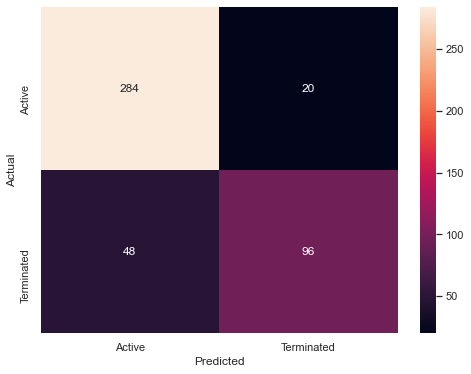

In [73]:
#Plot Confusion Matrix

#plot confusion matrix

conf_mat_lgbm = confusion_matrix(y_test, y_pred_lgbm)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat_lgbm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')

ax.xaxis.set_ticklabels(['Active', 'Terminated'])
ax.yaxis.set_ticklabels(['Active', 'Terminated'])


plt.show()

In [74]:
#Plot confusion matrix in dataframe
conf_mat_lgbm_df = pd.DataFrame(conf_mat_lgbm, columns = ['Predicted as Active', 'Predicted as Terminated'], index = ['Active', 'Terminated'] )
conf_mat_lgbm_df

,Predicted as Active,Predicted as Terminated
Active,284,20
Terminated,48,96


In [75]:
#Sensitivity and Specificity
pred_proba_lgbm_df = pd.DataFrame({'true_values': y_test, 'pred_probs': lgbm_model.predict_proba(X_test)[:,1]})
pred_proba_lgbm_df.head()

,true_values,pred_probs
2128,0,4.433497e-05
672,1,8.839967e-01
233,1,9.999990e-01
1475,0,1.898196e-10
1651,0,9.391178e-06


In [76]:
#predict the probability of the positive class (i.e., class 1) for the test data
y_probs_lgbm = lgbm_model.predict_proba(X_test)[:, 1]
X_test_proba = X_test.copy()
X_test_proba['probs'] = y_probs_lgbm

In [77]:
X_test.shape, X_test_proba.shape

((448, 99), (448, 100))

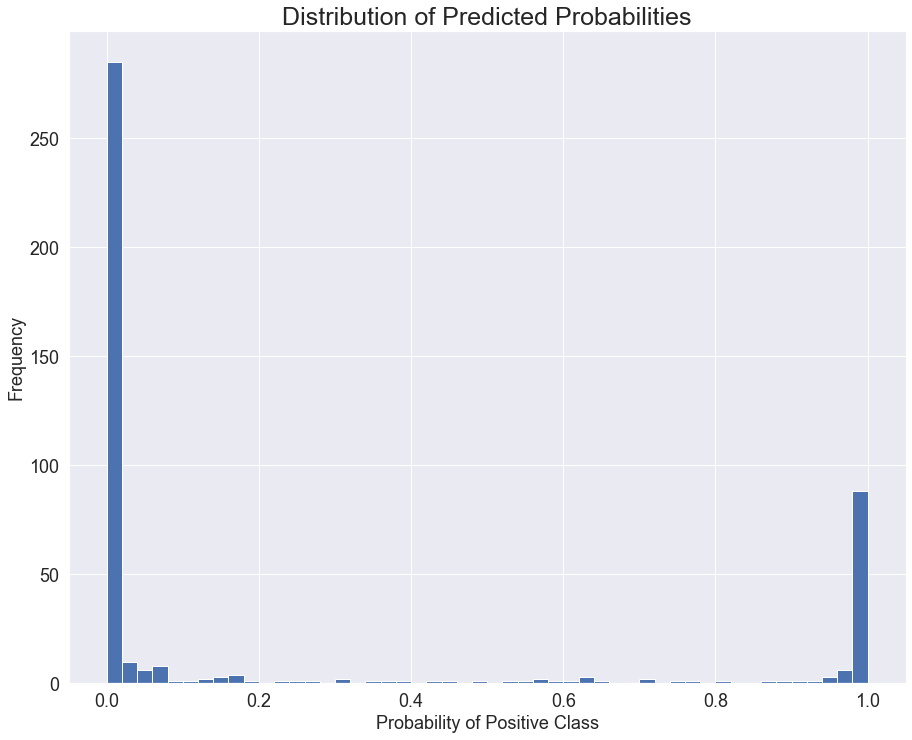

In [78]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 12))

ax.hist(X_test_proba['probs'], bins=50)
ax.set_xlabel('Probability of Positive Class', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_title('Distribution of Predicted Probabilities', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=18)

plt.show()

In [79]:
probs_binning = pd.cut(X_test_proba['probs'], bins=[0, 0.8, 1], labels=['others', 'highly likely'])
probs_binning_num = pd.cut(X_test_proba['probs'], bins=[0, 0.8, 1], labels=['0', '1'])

X_test_proba['probs binning'] = probs_binning
X_test_proba['probs binning num'] = probs_binning_num

In [80]:
X_test_proba['probs binning'].value_counts(normalize=True)

others           0.772321
highly likely    0.227679
Name: probs binning, dtype: float64

In [81]:
X_test_proba['probs binning'].value_counts()

others           346
highly likely    102
Name: probs binning, dtype: int64

In [82]:
#Save to csv
X_test_proba.to_csv('./1. Data/X_test_proba.csv', index=False)

In [83]:
X_raw = X.copy()
X_raw.shape

(2240, 99)

In [84]:
#predict the probability of the positive class (i.e., class 1) for the test data
y_probs_lgbm_raw = lgbm_model.predict_proba(X_raw)[:, 1]
X_raw_proba = X_raw.copy()
X_raw_proba['probs'] = y_probs_lgbm_raw

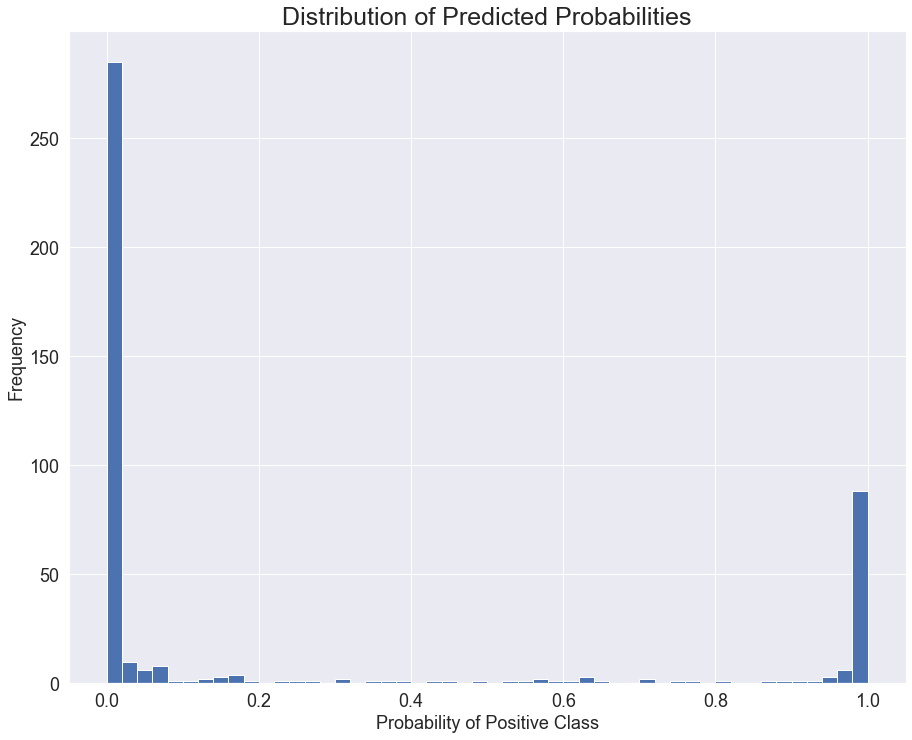

In [85]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 12))

ax.hist(X_test_proba['probs'], bins=50)
ax.set_xlabel('Probability of Positive Class', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_title('Distribution of Predicted Probabilities', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=18)

plt.show()

In [86]:
probs_binning = pd.cut(X_raw_proba['probs'], bins=[0, 0.8, 1], labels=['others', 'highly likely'])
probs_binning_num = pd.cut(X_raw_proba['probs'], bins=[0, 0.8, 1], labels=['0', '1'])

X_raw_proba['probs binning'] = probs_binning
X_raw_proba['probs binning num'] = probs_binning_num

In [87]:
X_raw_proba['probs binning'].value_counts(normalize=True)

others           0.689732
highly likely    0.310268
Name: probs binning, dtype: float64

In [88]:
X_raw_proba['probs binning'].value_counts()

others           1545
highly likely     695
Name: probs binning, dtype: int64

In [89]:
#Save to csv
X_raw_proba.to_csv('./1. Data/X_raw_proba.csv', index=False)

In [90]:
#Merge X_raw_proba with df2 to have terminated

In [91]:
df2_subset = df2[['HCM_PERSON_NUMBER', 'TERMINATED', 'TERMINATED_NUM']]

In [92]:
viz = pd.merge(X_raw_proba, df2_subset, on='HCM_PERSON_NUMBER')

In [93]:
X_raw_proba.shape, df2_subset.shape, viz.shape

((2240, 102), (2240, 3), (2240, 104))

In [94]:
#Save to csv
viz.to_csv('./1. Data/viz.csv', index=False)

In [95]:
#EDA on features (on original data set)
#EDA on highly likely (on X_test)

# Choose SVC

In [ ]:
#define classifier
clf = SVC(probability=True)

#define the pipeline - chain the preprocessor step and the classifier
pipe = Pipeline([('preprocessor',preprocessor), ('clf',clf)])
pipe.steps

In [97]:
#randomised search cv with hyper parameters
skf = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)
#input the parameters for search space

param_grid = {'clf__C': [0.1, 1, 10, 100, 1000], 
              'clf__gamma': [0.001, 0.01, 0.1, 1],
              'clf__kernel': ['linear','poly','rbf','sigmoid'],
              'clf__degree':[1,3]

}

#create the multinomial naive bayes classifier object
rscv_svc = RandomizedSearchCV(estimator = pipe, param_distributions=param_grid, scoring='f1_macro',cv=skf, random_state=22, verbose=1)


In [98]:
%%time

#fit the svc model with X-train and y_train data
svc_model = rscv_svc.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 2min 27s


In [99]:
svc_cross_val = cross_val_score(svc_model, X_train, y_train, cv = skf, scoring='f1_macro')
print(svc_cross_val.mean())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.7849868381880973


In [100]:
print ('Best parameters found by randomised search are:', svc_model.best_params_)

print ('Best accuracy from randomised search is:', svc_model.best_score_)

Best parameters found by randomised search are: {'clf__kernel': 'poly', 'clf__gamma': 0.1, 'clf__degree': 1, 'clf__C': 1}
Best accuracy from randomised search is: 0.7849868381880973


In [101]:
X_test.shape

(448, 99)

In [102]:
#predict the testing data first
y_pred_svc = svc_model.predict(X_test)

print(metrics.classification_report(y_test,y_pred_svc))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       304
           1       0.81      0.58      0.68       144

    accuracy                           0.82       448
   macro avg       0.82      0.76      0.78       448
weighted avg       0.82      0.82      0.81       448



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance

imps = permutation_importance(svc_model, X_test, y_test, n_repeats=15)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(imps.importances_mean)[::-1]

# Save all the features and their importances in a DataFrame
all_features_svc = pd.DataFrame({'Feature_svc': X.columns[indices],
                             'Importance': importances[indices]})
all_features_svc = all_features_svc[all_features_svc['Feature_svc'] != 'HCM_PERSON_NUMBER']
# Format 'Importance' to 4 decimal places
all_features_svc['Importance'] = all_features_svc['Importance'].apply(lambda x: "{:.4f}".format(x))

# Print the top 10 features
print("Top 10 Features:")
print(all_features_svc.head(10))

# Sort the DataFrame by 'Importance' in descending order
all_features_svc.sort_values(by='Importance', ascending=False, inplace=True)
all_features_svc


In [ ]:
top10_bar_svc = all_features_svc.head(10).sort_values(by='Importance', ascending=True)
# Plot the top 10 features
plt.figure(figsize=(10, 8))
plt.barh(top10_bar_svc.iloc[:10, 0], top10_bar_svc.iloc[:10, 1].astype(float), color="#2C5967", align='center')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title('SVM Permutation Importance')
plt.show()

In [ ]:
top10_svc = all_features_svc.head(10)
top10_svc

In [106]:
#Save to csv
top10_svc.to_csv('./1. Data/top10_svc.csv', index=False)

# Choose Random Forest

In [107]:
#use sklearn pipeline
from sklearn.pipeline import Pipeline

#define classifier
clf = RandomForestClassifier()

#define the pipeline - chain the preprocessor step and the classifier
pipe = Pipeline([('preprocessor',preprocessor), ('clf',clf)])

In [109]:
#randomised search cv with hyper parameters

skf = StratifiedKFold(n_splits=5, random_state=15, shuffle=True)
#input the parameters for search space
param_grid = {
    'clf__n_estimators':[500, 1000, 5000],
    'clf__max_features':['sqrt','log2'],
    'clf__max_depth': [5, 10, 15, 20],
    'clf__min_samples_split': [2,5,10,15],
    'clf__min_samples_leaf': [2,5,10,15],
    'clf__bootstrap': [True, False],
    'clf__criterion': ['gini','entropy']
}


#create the random forest classifier object

rscv_rf = RandomizedSearchCV(estimator = pipe, param_distributions=param_grid, scoring='f1_macro', cv = skf, verbose=1, random_state=24)


In [110]:
%%time

#fit the rf model with X-train and y_train data

rf_model = rscv_rf.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 2min 54s


In [111]:
print ('Best parameters found by randomised search are:', rf_model.best_params_)

print ('Best accuracy from randomised search is:', rf_model.best_score_)

Best parameters found by randomised search are: {'clf__n_estimators': 500, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 15, 'clf__criterion': 'gini', 'clf__bootstrap': True}
Best accuracy from randomised search is: 0.7798618145768694


In [112]:
#prediction on testing set first
y_pred_rf = rf_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       304
           1       0.91      0.54      0.68       144

    accuracy                           0.83       448
   macro avg       0.86      0.76      0.78       448
weighted avg       0.85      0.83      0.82       448



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance

imps = permutation_importance(rf_model, X_test, y_test, n_repeats=15)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(imps.importances_mean)[::-1]

# Save all the features and their importances in a DataFrame
all_features_rf = pd.DataFrame({'Feature_rf': X.columns[indices],
                             'Importance': importances[indices]})
all_features_rf = all_features_rf[all_features_rf['Feature_rf'] != 'HCM_PERSON_NUMBER']
# Format 'Importance' to 4 decimal places
all_features_rf['Importance'] = all_features_rf['Importance'].apply(lambda x: "{:.4f}".format(x))

# Print the top 10 features
print("Top 10 Features:")
print(all_features_rf.head(10))

# Sort the DataFrame by 'Importance' in descending order
all_features_rf.sort_values(by='Importance', ascending=False, inplace=True)
all_features_rf